# 目录

# 1 决策树回归DecisionTreeRegressor
 
# 2 岭回归Ridge

# 3 弹性网回归ElasticNet

# 4 算法融合

In [ ]:
%run 4-特征筛选.ipynb

In [6]:
train_y = train_num['SalePrice_log']
train_X = train_num.drop('SalePrice_log', axis=1)

In [7]:
model_column = train_X.columns
train_X.shape
model_column

(1458, 79)

Index(['LotFrontage', 'MasVnrArea', 'BsmtUnfSF', 'BsmtFullBath', 'HalfBath',
       'Fireplaces', 'WoodDeckSF', 'AllSF', 'MSSubClass_20', 'MSSubClass_60',
       'MSSubClass_70', 'MSSubClass_80', 'MSZoning_RL', 'LandContour_HLS',
       'LandContour_Lvl', 'LotConfig_Corner', 'LotConfig_CulDSac',
       'LotConfig_Inside', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
       'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Condition1_Norm',
       'BldgType_1Fam', 'YearBuilt_1941', 'YearBuilt_1965', 'YearBuilt_1977',
       'RoofStyle_Hip', 'Exterior1st_BrkFace', 'Exterior1st_CemntBd',
       'Exterior1st_Plywood', 'Exterior2nd_BrkFace', 'Exterior2nd_HdBoard',
       'Exterior2nd_VinylSd', 'Foundation_PConc', 'BsmtQual_4.0',
       'BsmtQual_5.0', 'Heating_GasA', 'CentralAir_Y', 'Electrical_SBrkr',
       'GarageType_Attchd', 'GarageType_BuiltIn', 'GarageYrBlt_1970.0',
       'GarageFinish_Fin', 'GarageFinish_RFn', 'MoSold_1', 'MoSold_10',
       'MoSold_11', 'MoSold_12', 'MoSold_2', 

# 1 决策树回归算法

In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# 参数优化 - GridSearchCV
# 交叉检验 - GridSearchCV
tuned_parameters = {"criterion": ["squared_error"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [2, 10, 20, 40],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [5, 10, 20, 40],
              }

clf = DecisionTreeRegressor()
clf = GridSearchCV(clf, tuned_parameters, cv=5)
clf.fit(train_X, train_y)

clf.best_params_

# Fixed
mean_scores = clf.cv_results_['mean_test_score']
std_scores = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']

for params, mean_score, scores in zip(params, mean_scores, std_scores):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * 2, params))

,estimator,DecisionTreeRegressor()
,param_grid,"{'criterion': ['squared_error'], 'max_depth': [2, 10, ...], 'max_leaf_nodes': [5, 10, ...], 'min_samples_leaf': [1, 5, ...], ...}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'squared_error'


{'criterion': 'squared_error',
 'max_depth': 10,
 'max_leaf_nodes': 40,
 'min_samples_leaf': 10,
 'min_samples_split': 10}

0.667 (+/-0.000) for {'criterion': 'squared_error', 'max_depth': 2, 'max_leaf_nodes': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.667 (+/-0.000) for {'criterion': 'squared_error', 'max_depth': 2, 'max_leaf_nodes': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}
0.667 (+/-0.000) for {'criterion': 'squared_error', 'max_depth': 2, 'max_leaf_nodes': 5, 'min_samples_leaf': 1, 'min_samples_split': 20}
0.667 (+/-0.000) for {'criterion': 'squared_error', 'max_depth': 2, 'max_leaf_nodes': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}
0.667 (+/-0.000) for {'criterion': 'squared_error', 'max_depth': 2, 'max_leaf_nodes': 5, 'min_samples_leaf': 5, 'min_samples_split': 10}
0.667 (+/-0.000) for {'criterion': 'squared_error', 'max_depth': 2, 'max_leaf_nodes': 5, 'min_samples_leaf': 5, 'min_samples_split': 20}
0.667 (+/-0.000) for {'criterion': 'squared_error', 'max_depth': 2, 'max_leaf_nodes': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}
0.667 (+/-0.000) for {'criterion': 'squared

<Figure size 2000x1000 with 0 Axes>

<Axes: >

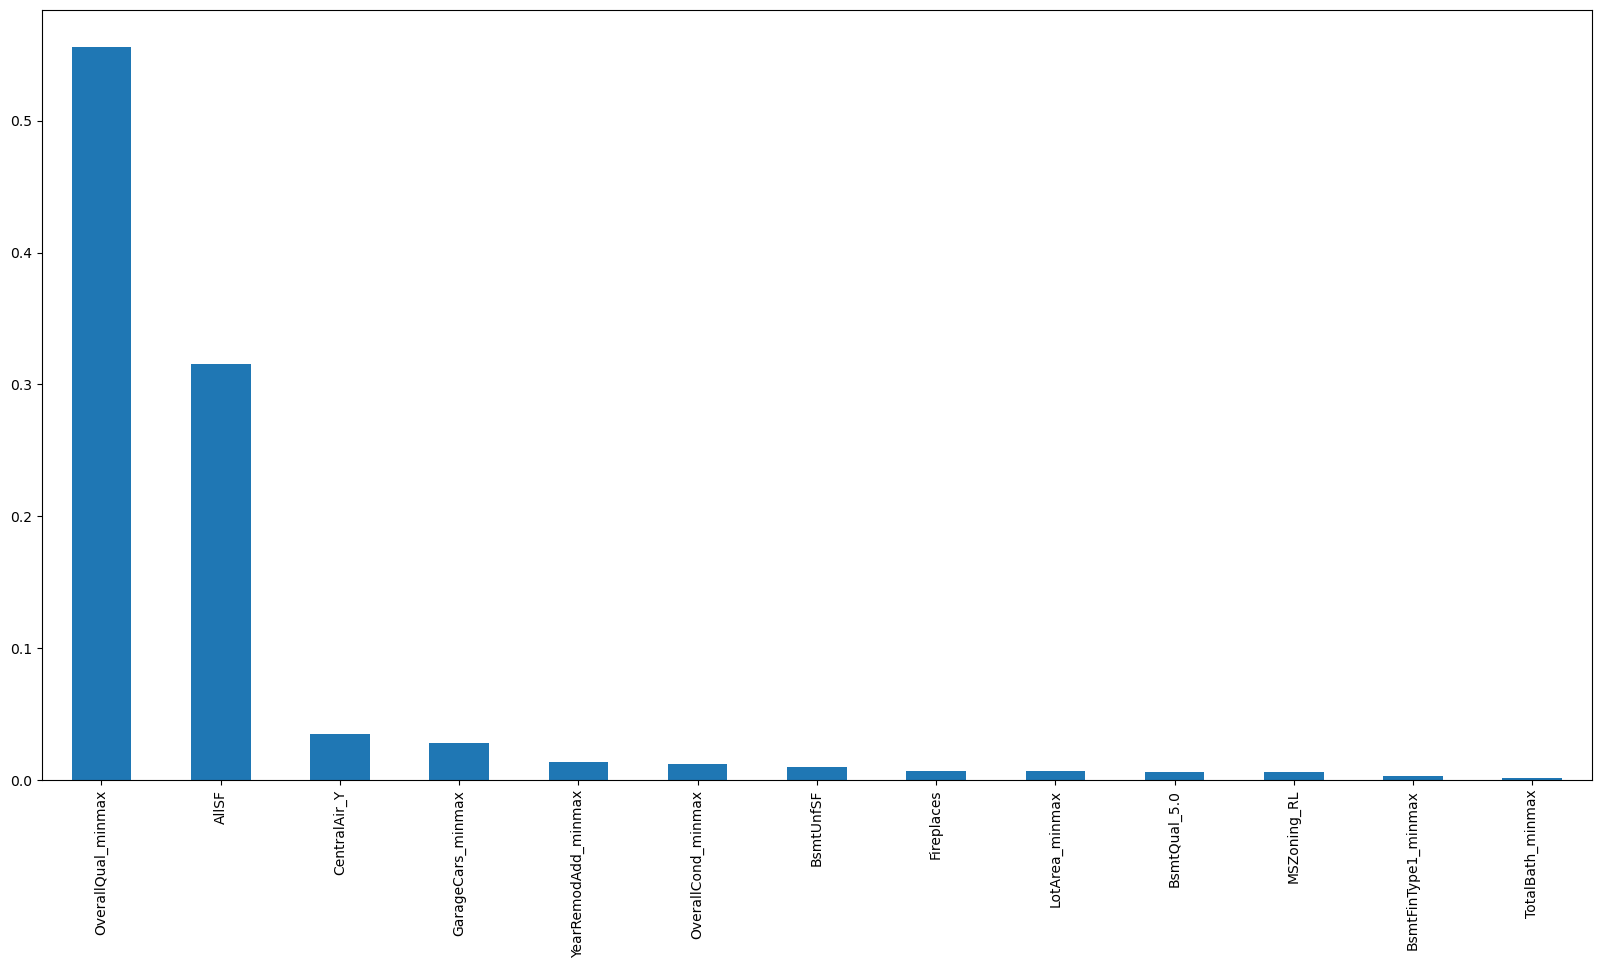

In [9]:
# 模型结果展示
# 变量重要性显示
important_features = pd.Series(data = clf.best_estimator_.feature_importances_, index = train_X.columns).sort_values(ascending = False)
important_features = important_features[important_features > 0]
plt.figure(figsize = (20, 10))
important_features.plot(kind = 'bar')

In [10]:
# 效果评估
from sklearn.metrics import mean_squared_error

pred_y = clf.predict(train_X)
np.sqrt(mean_squared_error(np.expm1(train_y), np.expm1(pred_y)))

24755.505797702233

<Figure size 2000x1000 with 0 Axes>

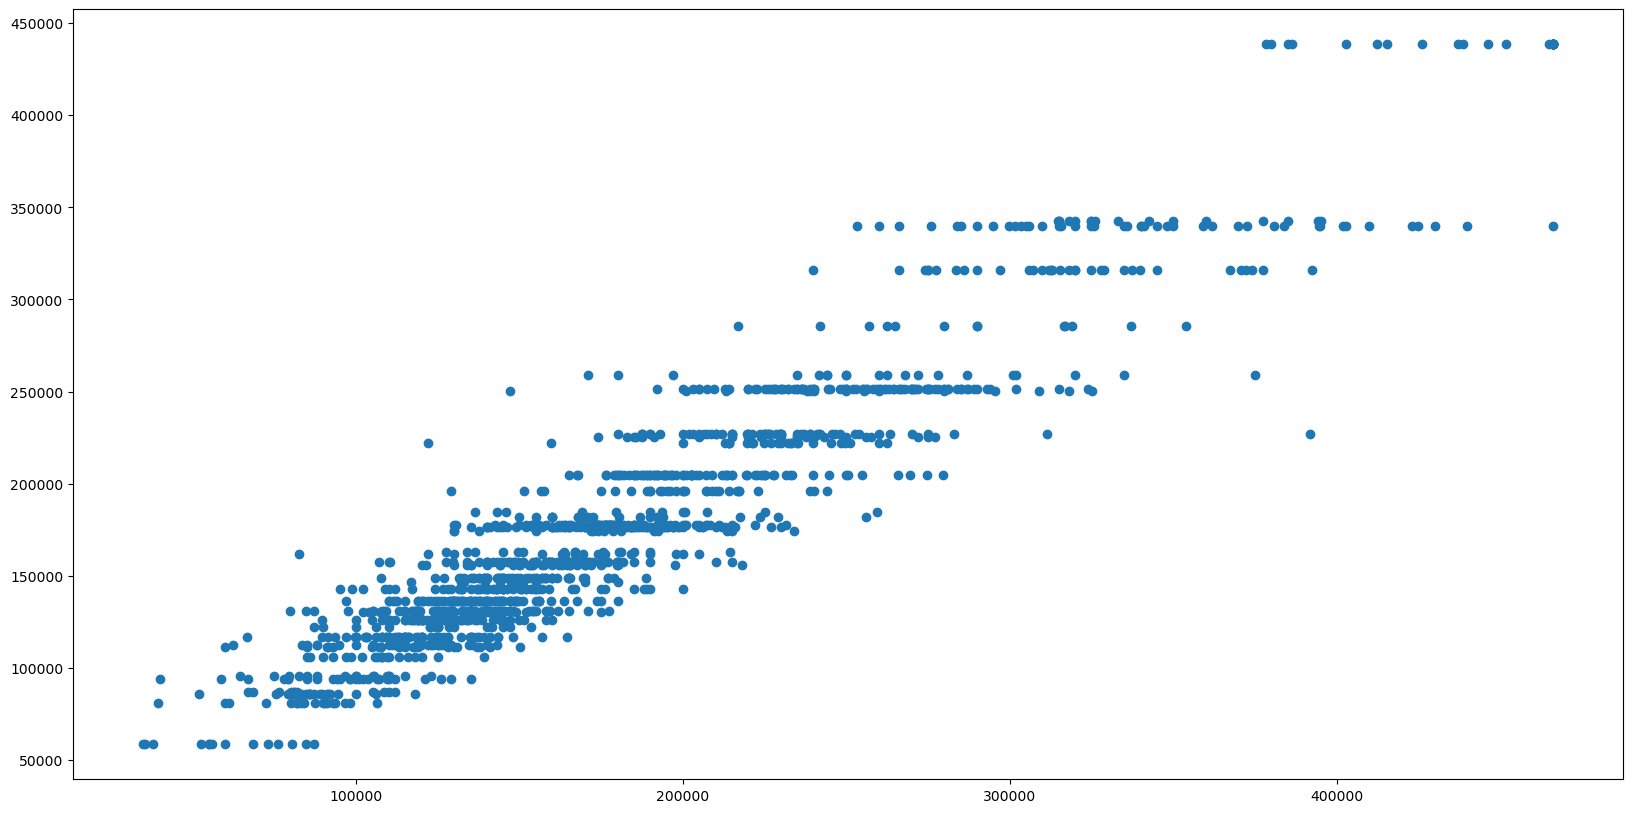

In [11]:
plt.figure(figsize=(20,10))
plt.scatter(x=np.expm1(train_y), y=np.expm1(pred_y))

# 2 岭回归Ridge

<Axes: title={'center': 'Validation - RidgeCV'}>

Text(0.5, 0, 'alpha')

Text(0, 0.5, 'rmse')

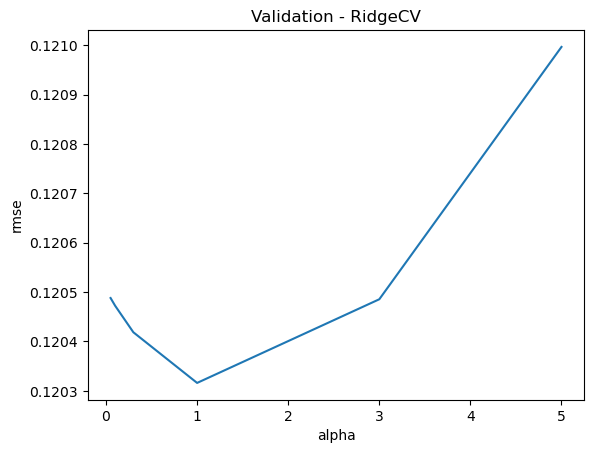

In [12]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# 参数优化 - for
# 交叉检验 - KFold
# 通过 5 折交叉验证，测试不同 α 对应的岭回归模型的 RMSE，找到最优 α
n_folds = 5
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, train_X, train_y, 
                                    scoring = "neg_mean_squared_error", 
                                    cv = KFold(n_folds, shuffle = True, random_state = 42)))
    return(rmse)

alphas = [0.05, 0.1, 0.3, 1, 3, 5]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]
# score.std()
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - RidgeCV")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [13]:
ridge = Ridge(alpha = 1)
ridge.fit(train_X, train_y)

,alpha,1
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


<Figure size 2000x1000 with 0 Axes>

<Axes: >

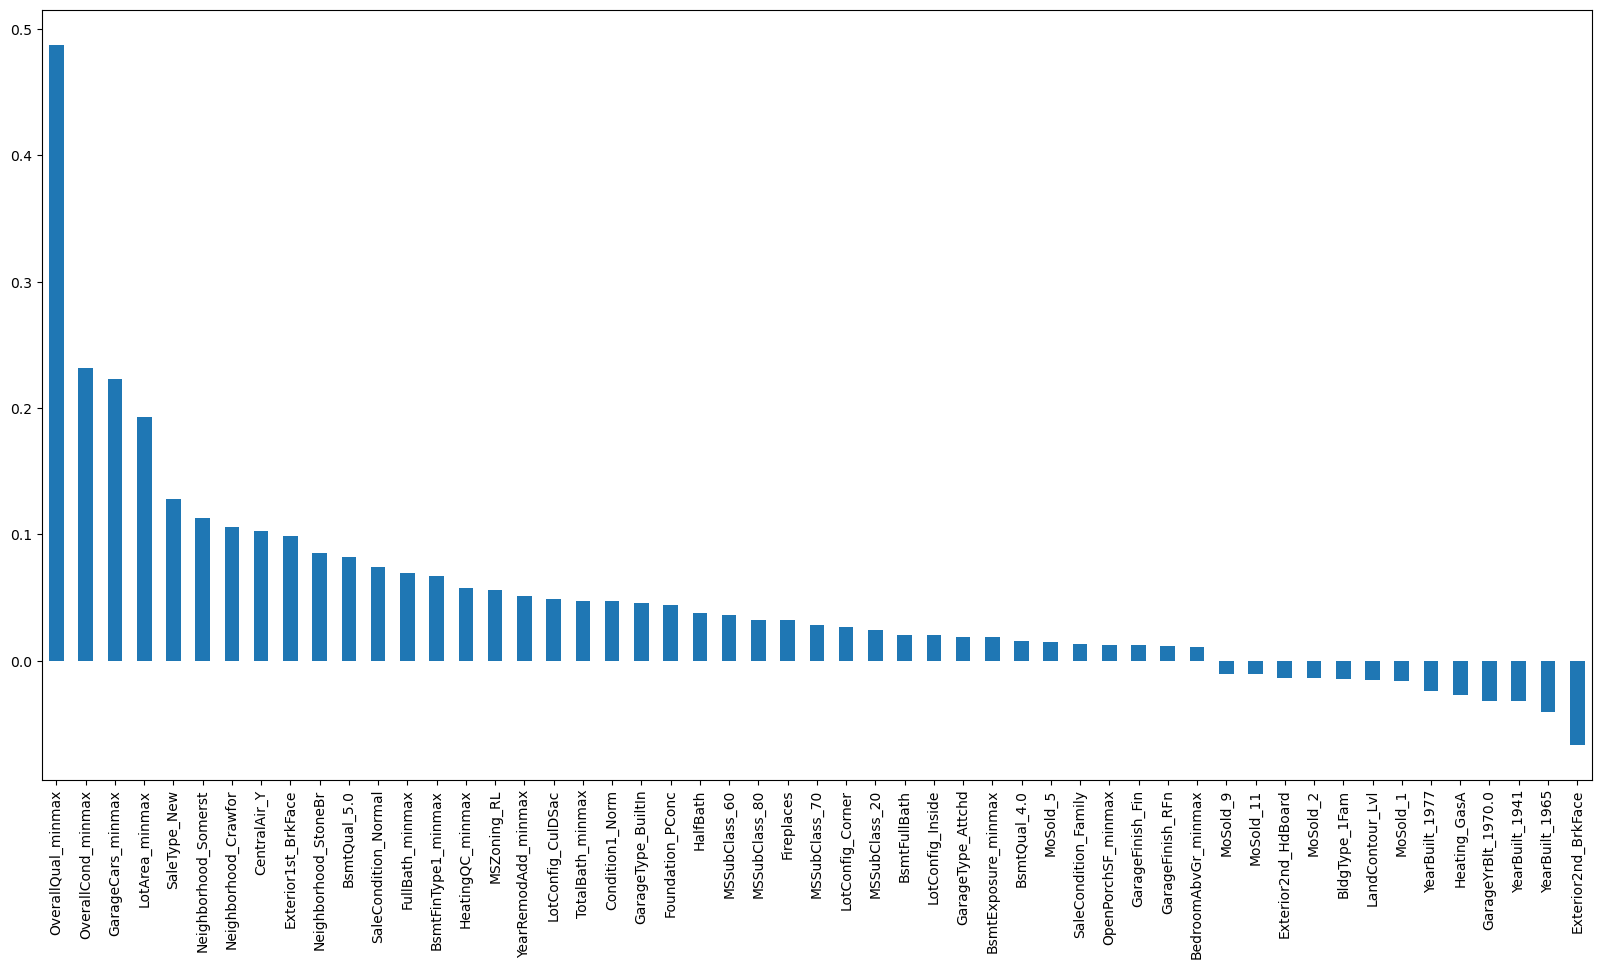

In [14]:
# 模型结果展示
# 变量重要性显示
important_features = pd.Series(data = ridge.coef_, index = train_X.columns).sort_values(ascending = False)
important_features = important_features[np.abs(important_features) > 0.01]
plt.figure(figsize=(20,10))
important_features.plot(kind='bar')

In [15]:
# 效果评估
from sklearn.metrics import mean_squared_error

pred_y = ridge.predict(train_X)
np.sqrt(mean_squared_error(np.expm1(train_y),  np.expm1(pred_y)))

20093.135065768554

<Figure size 2000x1000 with 0 Axes>

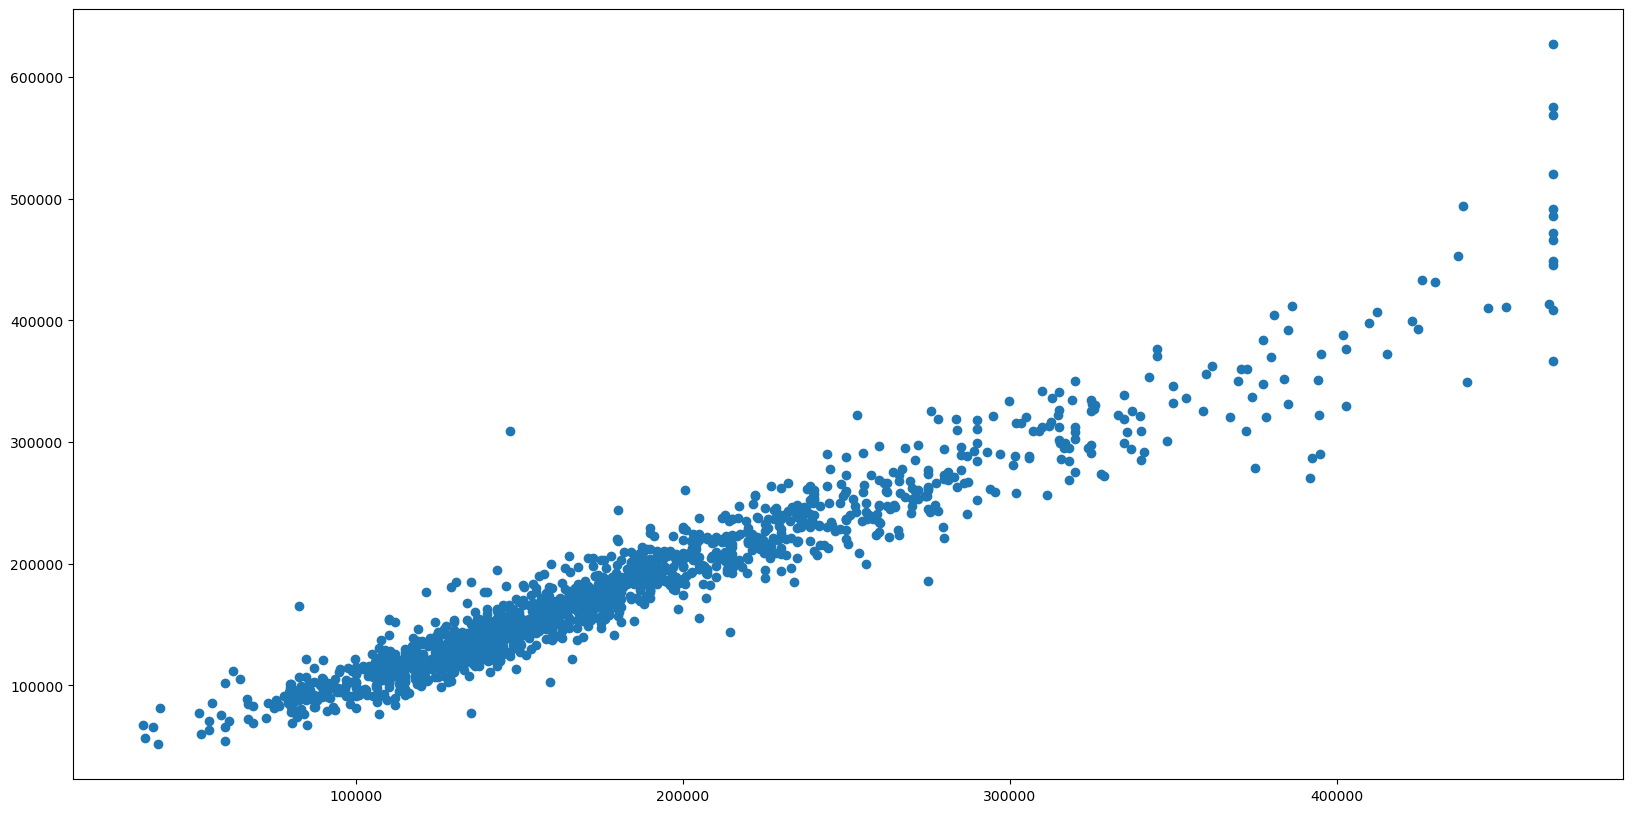

In [16]:
plt.figure(figsize=(20,10))
plt.scatter(x=np.expm1(train_y), y=np.expm1(pred_y))

# 3 弹性网回归ElasticNet

In [17]:
# 参数优化
# 交叉检验
from sklearn.linear_model import ElasticNetCV

elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(train_X, train_y)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(train_X, train_y)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(train_X, train_y)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

,l1_ratio,"[0.1, 0.3, ...]"
,eps,0.001
,n_alphas,'deprecated'
,alphas,"[0.0001, 0.0003, ...]"
,fit_intercept,True
,precompute,'auto'
,max_iter,50000
,tol,0.0001
,cv,10
,copy_X,True
,verbose,0


Best l1_ratio : 0.95
Best alpha : 0.0006
Try again for more precision with l1_ratio centered around 0.95


,l1_ratio,"[0.8075, 0.855, ...]"
,eps,0.001
,n_alphas,'deprecated'
,alphas,"[0.0001, 0.0003, ...]"
,fit_intercept,True
,precompute,'auto'
,max_iter,50000
,tol,0.0001
,cv,10
,copy_X,True
,verbose,0


Best l1_ratio : 0.95
Best alpha : 0.0006
Now try again for more precision on alpha, with l1_ratio fixed at 0.95 and alpha centered around 0.0006


,l1_ratio,0.95
,eps,0.001
,n_alphas,'deprecated'
,alphas,"[0.00035999999999999997, 0.00039, ...]"
,fit_intercept,True
,precompute,'auto'
,max_iter,50000
,tol,0.0001
,cv,10
,copy_X,True
,verbose,0


Best l1_ratio : 0.95
Best alpha : 0.00057


In [18]:
# 模型稳定性
score = rmse_cv(elasticNet)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1194 (0.0090)



<Figure size 2000x1000 with 0 Axes>

<Axes: >

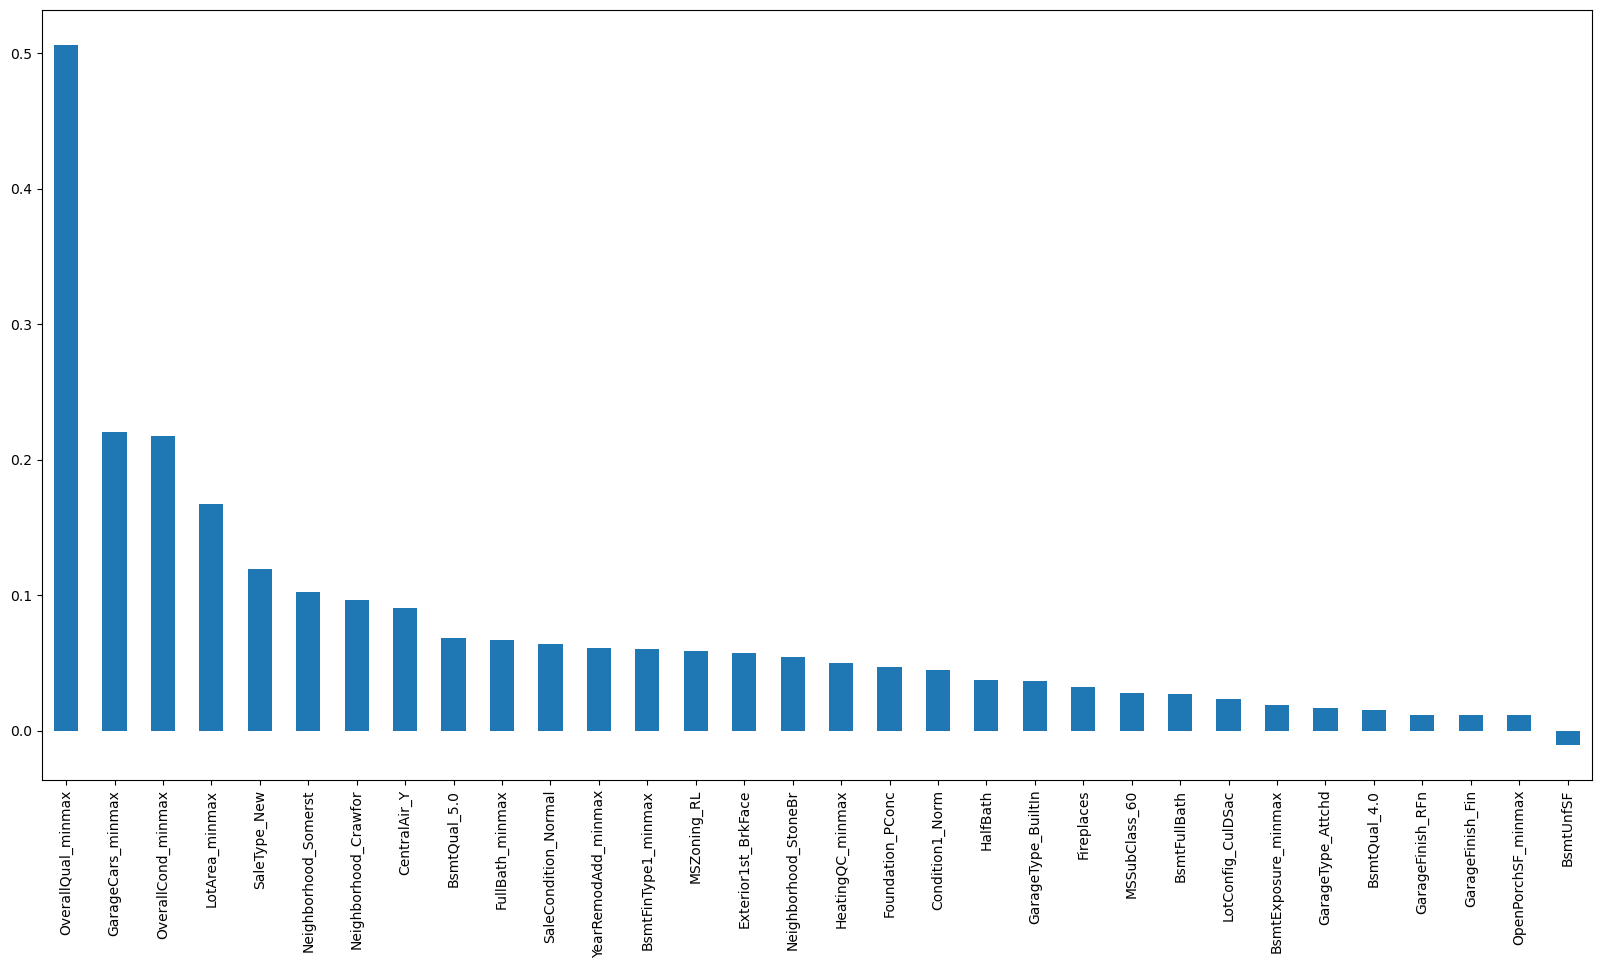

In [19]:
# 模型结果展示
# 变量重要性显示
important_features = pd.Series(data=elasticNet.coef_, index=train_X.columns).sort_values(ascending=False)
important_features = important_features[np.abs(important_features)>0.01]
plt.figure(figsize=(20,10))
important_features.plot(kind='bar')

In [20]:
# 效果评估
from sklearn.metrics import mean_squared_error

pred_y = elasticNet.predict(train_X)

np.sqrt(mean_squared_error(np.expm1(train_y),  np.expm1(pred_y)))

20376.368544093788

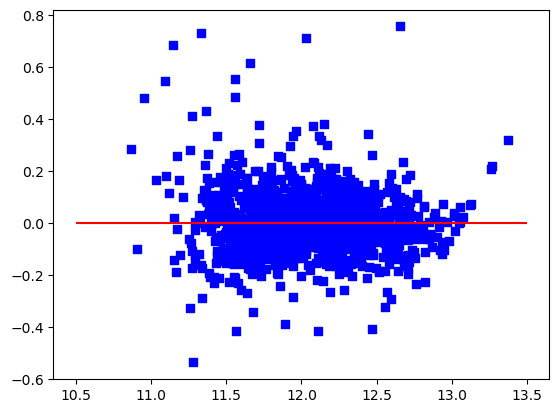

In [21]:
# 效果评估展示
plt.scatter(pred_y, pred_y - train_y, c = "blue", marker = "s", label = "Training data")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")

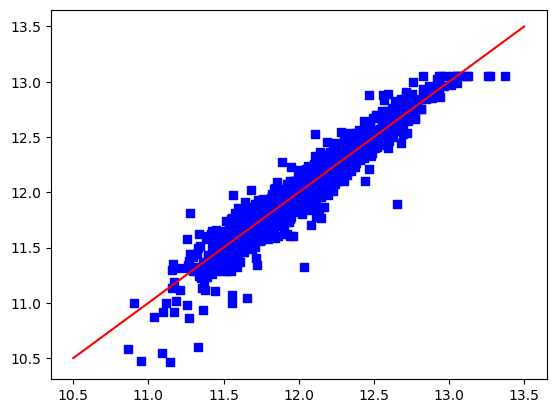

In [22]:
# Plot predictions
plt.scatter(pred_y, train_y, c = "blue", marker = "s", label = "Training data")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")

# 4 算法融合

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.base import RegressorMixin
from sklearn.base import TransformerMixin
from sklearn.base import clone

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
    
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models] # tip: 这里是为了生成全新的模型实例，从而可以复用fit

        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)
        return self  # sklearn接口规范（支持链式调用，如model.fit(X,y).predict(X)
    
    # Now we do the preditions for cloned models and average them
    def predict(self, X):
        # 用每个训练好的模型预测，结果按列堆叠（比如2个模型→n行2列的数组）
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis = 1)

In [25]:
# 模型相关性分析
pred_y_ridge = ridge.predict(train_X)
pred_y_elasticNet = elasticNet.predict(train_X)
pred_y_clf = clf.predict(train_X)

from scipy.stats import pearsonr
pearsonr(pred_y_ridge.T, pred_y_elasticNet.T)
pearsonr(pred_y_clf.T, pred_y_elasticNet.T)

PearsonRResult(statistic=0.9989654860105703, pvalue=0.0)

PearsonRResult(statistic=0.9505648741071323, pvalue=0.0)

In [26]:
# 模型训练
averaged_models = AveragingModels(models = (ridge, elasticNet))
averaged_models.fit(train_X, train_y)

,models,"(Ridge(alpha=1), ...)"


In [27]:
# 交叉验证
n_folds = 5
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, train_X, train_y, scoring="neg_mean_squared_error", 
                                   cv = KFold(n_folds, shuffle=True, random_state=42)))
    return(rmse)
score = rmse_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
#  相关性未去除 ：Averaged base models score: 0.1124 (0.0090)
#  单独 elasticNet ：Averaged base models score: 0.1180 (0.0081)

 Averaged base models score: 0.1195 (0.0094)



In [29]:
# 效果评估
from sklearn.metrics import mean_squared_error

pred_y = averaged_models.predict(train_X)

np.sqrt(mean_squared_error(np.expm1(train_y),  np.expm1(pred_y)))

20161.37068485075

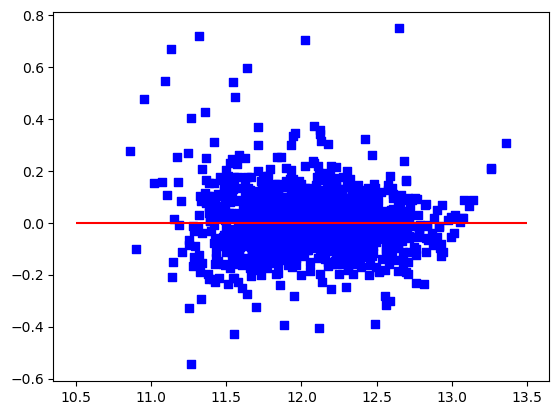

In [30]:
# 效果评估展示
plt.scatter(pred_y, pred_y - train_y, c = "blue", marker = "s", label = "Training data")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")

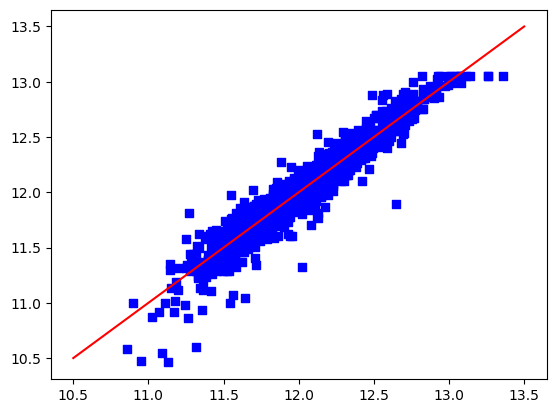

In [31]:
# Plot predictions
plt.scatter(pred_y, train_y, c = "blue", marker = "s", label = "Training data")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")

# 最终模型

In [32]:
model_ridge = ridge
model_elasticNet = elasticNet
model_averaged_models = averaged_models